### Imports:

In [1025]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time


import re

from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras import optimizers

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, roc_curve, auc

%matplotlib inline

### Load the Data:

In [4]:
has_planets = pd.read_csv('../clean_planet_data/clean_labeled_planets.csv')

c4_kep = pd.read_csv('../clean_planet_data/clean_kep_c4.csv')

all_confirmed = pd.read_csv('../clean_planet_data/all_planets_list.csv')

### Making sure there are transits in the confirmed planets set:

In [3]:
# remove last line from c4_kep because it has too many nulls:
c4_kep.drop(index=7713, inplace = True)

In [6]:
# Assign what used to be exposure to 0 because we're about to change that variable
c4_kep['1'] = 0

In [7]:
# Assign labels to c4_kep
not_found = 0
stars_to_drop = []

for j in range(len(c4_kep)): # for every light curve from has_planets
    if j % 250 == 0:
        print(j)

    count = 0
    for i in range(len(all_confirmed)): # look through each star name in the list of all confirmed planets
        try:
            if all_confirmed.loc[i, 'Alternative star names'].find(c4_kep.iloc[j, 0]) != -1:
                count += 1
                print(c4_kep.iloc[j, 0], ' found @ index: ', j, 'orbital period: ', all_confirmed.loc[i, 'Orbital period [days]'])
                c4_kep.loc[j, '1'] = 1
    
        except AttributeError: # if the alternate star names value are null
            try:
                if all_confirmed.loc[i, 'Star name'].find(c4_kep.iloc[j, 0]) != -1:
                    count += 1
                    print(c4_kep.iloc[j, 0], ' found @ index: ', j, 'on 2nd level of loop', 'orbital period: ', all_confirmed.loc[i, 'Orbital period [days]'])
                    c4_kep.loc[j, '1'] = 1
                    
            except AttributeError: # if this is null too, keep going
                continue
    if count == 0:
        not_found += 1


0
KIC 10000941  found @ index:  174 orbital period:  3.5047±0.0000
250
KIC 10002866  found @ index:  265 orbital period:  3.9370±0.0000
KIC 10002866  found @ index:  265 orbital period:  28.0819±0.0001
KIC 10002866  found @ index:  265 orbital period:  10.0888±0.0000
KIC 10004519  found @ index:  328 orbital period:  9.8032±0.0000
KIC 10004738  found @ index:  338 orbital period:  56.4754±0.0002
KIC 10004738  found @ index:  338 orbital period:  92.8761±0.0008
KIC 10004738  found @ index:  338 orbital period:  13.9307±0.0001
KIC 10005788  found @ index:  398 orbital period:  10.9947±0.0000
KIC 10006581  found @ index:  430 orbital period:  40.1100±0.0002
500
KIC 10010440  found @ index:  502 orbital period:  53.5991±0.0004
KIC 10018233  found @ index:  691 orbital period:  16.2960±0.0001
KIC 10019065  found @ index:  744 orbital period:  52.6298±0.0003
750
KIC 10019643  found @ index:  771 orbital period:  21.3473±0.0001
KIC 10019643  found @ index:  771 orbital period:  7.8109±0.0001


In [8]:
c4_kep['1'].value_counts() # I counted only 6 stars with no planets with an orbit under 66 days in this set 
# indexes: 913, 986, 1028, 1099, 1553, 7167

0    7642
1      71
Name: 1, dtype: int64

In [11]:
c4_kep.drop(index = [913, 986, 1028, 1099, 1553, 7167], inplace=True)

In [12]:
c4_kep.reset_index(drop=True, inplace=True)

In [13]:
c4_kep.shape

(7707, 4158)

<hr>

# Preprocessing Data:
### Mix confirmed planets into data so the model can learn what they are like.

In [14]:
# cut out the extra data to compare across the same timeline (~3200 points)
join_planets = has_planets.iloc[:,:3199]

# split c4_kep to add to training data
to_train_on = c4_kep.head(2705).iloc[:,:3199]

# set aside the last 5000 stars as a holdout set
c4_holdout = c4_kep.tail(5000).iloc[:,:3199]

In [28]:
join_planets = join_planets.head(1129) # there are null rows at the bottom of this df

In [30]:
master_df = pd.concat([join_planets, to_train_on], axis = 0)

In [36]:
# Calculate Baseline Accuracy
val_count = master_df['1'].value_counts()
base_acc = val_count[1] / val_count.sum()

print('Baseline Acc: ', base_acc)
print(val_count)

Baseline Acc:  0.30073030777256127
0.0    2681
1.0    1153
Name: 1, dtype: int64


### Scaling
Normalize the light curves so that stars of different brightnesses can be compared.

In [37]:
# Make X and y
X = master_df.iloc[:, 2:]
y = master_df['1']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [38]:
# instantiate StandardScaler as ss
ss = StandardScaler()

In [39]:
# transpose to scale each lightcurve row (rather than columns)
X_train = X_train.T
X_test = X_test.T

# Scaling
scaled_df = ss.fit_transform(X_train)
X_train = pd.DataFrame(scaled_df, columns=X_train.columns)

test_scaled_df = ss.fit_transform(X_test)
X_test = pd.DataFrame(test_scaled_df, columns=X_test.columns)

# Transpose back to normal
X_train = X_train.T
X_test = X_test.T

In [40]:
# make into an array and then change the dimensions
X_array = np.array(X_train)
X_array = np.expand_dims(X_array, axis = 2)

# do this for the test set too
X_test_array = np.array(X_test)
X_test_array = np.expand_dims(X_test_array, axis = 2)

### Prepare Unseen Dataset:

In [41]:
# slice out the light curve
unseen_data = c4_holdout.iloc[:,2:3199]

# Scale
unseen_data = unseen_data.T # transpose to scale each lightcurve row (rather than columns)

scaled_unseen = ss.fit_transform(unseen_data)
unseen_data = pd.DataFrame(scaled_unseen, columns=unseen_data.columns)

unseen_data = unseen_data.T # Transpose back to normal

# Change the dimensions so it can be put through the neural network
array_unseen = np.array(unseen_data)
array_unseen = np.expand_dims(array_unseen, axis = 2)

<hr>

# Define Functions for Evaluating the Results Later:

In [1055]:
# This will be used later to show how the model learned over the epochs

def learning_plots(title, metric, val_metric, y_label, c_train='#1f77b4', c_test='orange'):

    # Instantiate plot
    plt.figure()

    # Plot metric of interest
    plt.plot(result.history[metric], color = c_train)
    plt.plot(result.history[val_metric], color = c_test)

    # Set title
    plt.title(title)

    # Set axis labels
    plt.ylabel(y_label)
    plt.xlabel('Epoch (# of iterations)')

    # Add a legend
    plt.legend(['Train', 'Test'], loc='best')

    # Plot girdlines:
    plt.grid()

    plt.show();

This will be used for showing the evaluation metrics.

In [1112]:
def analyze_results(predictions, y_test): #, all_results):


    # Calculate 
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    total = (tp + tn + fp + fn)

    
    index_labels = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision']
    scores = pd.DataFrame(index = index_labels, columns=['Results'])
    
# Calculate results
    decimals = 3

    scores.loc['Accuracy'] = round((tp+tn) / (total), decimals)
    scores.loc['Sensitivity'] = round(tp / (tp+fn), decimals)
    scores.loc['Specificity'] = round(tn / (tn+fp), decimals)
    scores.loc['Precision'] = round(tp / (tp+fp), decimals)

    # Display the rounded results
    display(scores)
    
# Calculate values for the confusion matrix

    confusion = pd.DataFrame(index= ['Pred. Positive','Pred. Negative', 'Total'])

    confusion['Act. Positive'] = tp, fn, (tp + fn)
    confusion['Act. Negative'] = fp, tn, (fp + tn)

    confusion['Total'] = (tp + fp), (fn + tn), total

    display(confusion)
    
    print((tp + fp), 'predicted to have planets', '\n',
    tp, 'true positive planet stars predicted', '\n',
    round(tp/(tp+fn)*100, 3), '% of all true planets', '\n') 
    
    # Rate of planets in predictions
    tp_rate = (tp / (tp + fp))
    # Rate of planets in all unseen test set
    all_rate = (tp + fn) / total
    
    print(round(tp_rate / all_rate, 3), 'times better than chance')
    
    # False positive rate
    print(round(fp/(tp+fp)*100, 3), '% false positive rate')
    
    return scores, confusion

This will be used to plot the auc-roc curve when evaluating the predictions.

In [1121]:
def plot_roc(y_test, y_hat_proba):
# Plot ROC-AUC curve

    # Generate False positive rate and True positive rate
    fpr, tpr, _ = roc_curve(y_test, y_hat_proba)
    roc_auc = auc(fpr, tpr)

# Plot settings
    plt.figure(figsize=(6, 4))
    line_width = 4
    
    # Title and labels
    plt.title('ROC Curve', fontsize=25, position = (0.2,1))
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    
    # Gridlines
    plt.grid(True)
    
    plt.plot(fpr, tpr, lw = line_width)
    plt.plot([0, 1], [0,1], lw = line_width, linestyle = '--')

<hr>

# Modeling:
### Nueral Network Architecture:

In [ ]:
# To Tune further:
#     Pooling layers between all convolutional layers

In [1150]:
# Define model architecture
model = Sequential()

# Convolutional and layer.
model.add(Conv1D(filters = 15, # tuned for 5, 15 second round
                 kernel_size = (20),  # filter size, tuned for 15, 20 second round
                 activation = 'relu',
                 input_shape = (3197, 1))) # dimensions of training data

# Convolutional layer
model.add(Conv1D(filters = 20,
                 kernel_size = 30, # best so far 30
                 activation = 'relu'))

# Convolutional layer
model.add(Conv1D(filters = 15,
                 kernel_size = 60, # best so far 60
                 activation = 'relu'))


# Pooling:
model.add(MaxPooling1D(pool_size = (3))) # best so far 3
model.add(Dropout(0.2)) # best so far .2







# # Convolutional layer
# model.add(Conv1D(filters = 7,
#                  kernel_size = 20,
#                  activation = 'relu'))
# # # Pooling layer.
# model.add(MaxPooling1D(pool_size = (5)))
# # model.add(Dropout(0.25))




# Convolutional layer
model.add(Conv1D(filters = 7, # tuned for 7, confirmed second round
                 kernel_size = 20, # tuned for 7, 20 second round
                 activation = 'relu'))
# Pooling layer.
model.add(MaxPooling1D(pool_size = (5))) #tuned for 7, 5 second round
model.add(Dropout(0.25)) # regularization tuned for .25, confirmed 2nd round




# # Convolutional layer
# model.add(Conv1D(filters = 7,
#                  kernel_size = 20,
#                  activation = 'relu'))

# Convolutional layer
model.add(Conv1D(filters = 10, # tuned to 10, confirmed 2nd round
                 kernel_size = 30, # tuned to 10, second round ~30
                 activation = 'relu'))
# Pooling layer.
model.add(MaxPooling1D(pool_size = (5))) # tuned to 5, confirmed 2nd round
model.add(Dropout(0.5)) # regularization tuned to .5






# Organize neurons by flattening.
model.add(Flatten())

# Fully connected hidden layers.

# Hidden layer 1
model.add(Dense(2500, activation = 'relu')) # 1st round- 2500, .7 drop
model.add(Dropout(0.4)) # best so far .4

model.add(Dense(1500, activation = 'relu')), # 1st round- 1000, .7 drop, 2nd best so far 1500, .4 drop
model.add(Dropout(0.5)) # best so far .5?

# model.add(Dense(500, activation = 'relu'))



# Output layer
model.add(Dense(1, activation = 'sigmoid'))

# Setting learning rate and decay
learn_rate = 0.001
# # x% reduction in learing_rate by epoch: coef_by_epoch
# coef_reduce = .75
# coef_by_epoch = 30

# Calculate decay
decay = 0 #(learn_rate - (coef_reduce * learn_rate)) / coef_by_epoch

# Changing adam optimization parameters
optimizers.adam(lr = learn_rate, decay = decay)

# Compile model
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
# Keep track of the runtime:
start_time = time.time()

# Fit the model:
result = model.fit(X_array,
                    y_train,
                    batch_size = 64,
                    epochs = 40,
                    verbose = 1,
                   validation_data = (X_test_array, y_test))

# Print the runtime:
print('Runtime: ', round((time.time() - start_time)/60, 3), ' minutes')

Train on 2875 samples, validate on 959 samples
Epoch 1/40
2875/2875 [==============================] - 163s 57ms/step - loss: 0.6103 - acc: 0.6908 - val_loss: 0.6106 - val_acc: 0.6997
Epoch 2/40
2875/2875 [==============================] - 121s 42ms/step - loss: 0.5982 - acc: 0.6991 - val_loss: 0.6175 - val_acc: 0.6997
Epoch 3/40
2875/2875 [==============================] - 123s 43ms/step - loss: 0.5881 - acc: 0.6991 - val_loss: 0.5968 - val_acc: 0.7007
Epoch 4/40
2875/2875 [==============================] - 130s 45ms/step - loss: 0.5793 - acc: 0.6984 - val_loss: 0.5414 - val_acc: 0.7018
Epoch 5/40
2875/2875 [==============================] - 128s 45ms/step - loss: 0.5736 - acc: 0.7110 - val_loss: 0.5487 - val_acc: 0.7278
Epoch 6/40
2875/2875 [==============================] - 122s 43ms/step - loss: 0.5523 - acc: 0.7287 - val_loss: 0.5331 - val_acc: 0.7581
Epoch 7/40
2875/2875 [==============================] - 122s 42ms/step - loss: 0.5418 - acc: 0.7457 - val_loss: 0.5126 - val_acc: 0

### Network Training Plots:
Training accuracy and loss functions vs. epochs

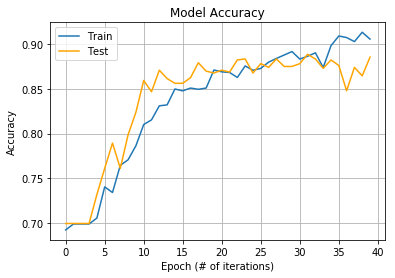

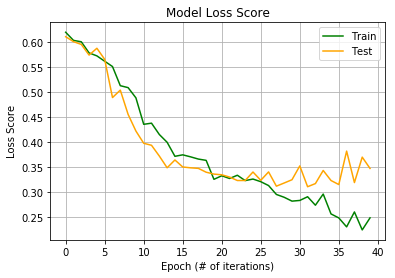

In [1146]:
# Plot accuracy over epochs
learning_plots(title = 'Model Accuracy', 
               metric = 'acc', 
               val_metric = 'val_acc', 
               y_label = 'Accuracy')

# Plot loss score over epoch
learning_plots(title = 'Model Loss Score', 
               metric = 'loss', 
               val_metric = 'val_loss', 
               y_label = 'Loss Score',
              c_train = 'green',
              c_test = 'orange')

### Testing on Unseen Data:
Now that the model has been fit, lets see if we can use it to detect some planets in data not seen before.

In [1147]:
# Make Predictions
y_unseen = model.predict_classes(array_unseen)
# Predict probabilities
pred_proba = model.predict_proba(array_unseen)

# make df of true labels and index
true_y_unseen = c4_holdout['1']

In [1148]:
# Run the analyze_results function
results_df, confusion_df = analyze_results(predictions = y_unseen, 
                                           y_test = true_y_unseen)

,Results
Accuracy,0.964
Sensitivity,0.244
Specificity,0.97
Precision,0.063


,Act. Positive,Act. Negative,Total
Pred. Positive,10,149,159
Pred. Negative,31,4810,4841
Total,41,4959,5000


159 predicted to have planets 
 10 true positive planet stars predicted 
 24.39 % of all true planets 

7.67 times better than chance
93.711 % false positive rate


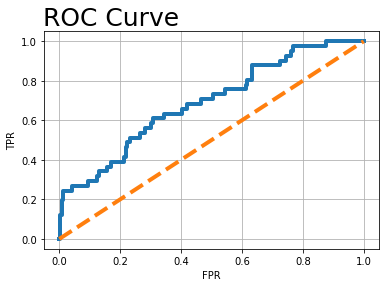

In [1149]:
# Plot auc-roc curve
plot_roc(true_y_unseen, pred_proba)